In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
import warnings
warnings.filterwarnings('ignore')
#pd.set_option("display.max_columns",50)

In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.preprocessing import StandardScaler,MinMaxScaler,MaxAbsScaler
from sklearn.model_selection import cross_val_score,GridSearchCV,StratifiedKFold,RepeatedStratifiedKFold,RandomizedSearchCV
from sklearn.metrics import accuracy_score,auc,recall_score,precision_score,precision_recall_curve,confusion_matrix,\
plot_confusion_matrix,plot_precision_recall_curve,plot_roc_curve,classification_report,roc_auc_score,f1_score
from xgboost import XGBClassifier
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import SimpleImputer,KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer,MissingIndicator,SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [3]:
import re
import seaborn as sns
from matplotlib import pyplot as plt
sns.set(style="darkgrid") #white, dark, whitegrid, darkgrid, ticks


In [4]:
def data_info(df):
    df_info = pd.DataFrame(df.isna().sum(),columns = ['Null_count'])
    df_info['Non_Null_count'] = df_info.index.map(df.notna().sum())
    df_info['N_unique'] = df_info.index.map(df.nunique())
    df_info['D_types'] = df_info.index.map(df.dtypes)
    df_info['Blank_count'] = df_info.index.map((df=='').sum())
    return df_info

In [5]:
path = "/home/op_2344_appmon/_392256_vishnu/CHBT"

In [6]:
import zipfile
zf = zipfile.ZipFile(f'{path}/data_analysis.zip') 
zf.namelist()

['a.data.csv',
 'a.lbl.csv',
 'instructions.txt',
 'm.data.csv',
 'm.lbl.csv',
 'p.data.csv',
 'p.lbl.csv']

### reading sensor data and labels

In [7]:
a_data = pd.read_csv(zf.open('a.data.csv'))
a_data['data_name'] = 'a'
m_data = pd.read_csv(zf.open('m.data.csv'))
m_data['data_name'] = 'm'
p_data = pd.read_csv(zf.open('p.data.csv'))
p_data['data_name'] = 'p'
a_lbl = pd.read_csv(zf.open('a.lbl.csv'),)
a_lbl['data_name'] = 'a'
m_lbl = pd.read_csv(zf.open('m.lbl.csv'))
m_lbl['data_name'] = 'm'
p_lbl = pd.read_csv(zf.open('p.lbl.csv'))
p_lbl['data_name'] = 'p'
f'shape of a_data : {a_data.shape} & shape of a_label : {a_lbl.shape}'
f'shape of m_data : {m_data.shape} & shape of a_label : {m_lbl.shape}'
f'shape of p_data : {p_data.shape} & shape of a_label : {p_lbl.shape}'

'shape of a_data : (71642, 11) & shape of a_label : (10, 3)'

'shape of m_data : (21325, 11) & shape of a_label : (328, 3)'

'shape of p_data : (70902, 11) & shape of a_label : (290, 3)'

In [8]:
a_lbl.head()

,timestamp(ms),label (0=start 1=end 2=cancel),data_name
0,1397019861612,0,a
1,1397019866475,1,a
2,1397019887463,0,a
3,1397019888154,1,a
4,1397020224082,0,a


### concatinating all 3 files

In [9]:
data = pd.concat([a_data,m_data,p_data], axis = 0).reset_index(drop = True).sort_values('timestamp(ms)')
target = pd.concat([a_lbl,m_lbl,p_lbl], axis = 0).reset_index(drop = True).sort_values('timestamp(ms)')

### changing column names

In [10]:
data.columns = [re.sub(r'\(.*\)', '', i) for i in data.columns]
target.columns = [re.sub(r'\s*\(.*\)', '', i) for i in target.columns] #r'\([^)]*\)'

In [11]:
data_info(data)

,Null_count,Non_Null_count,N_unique,D_types,Blank_count
timestamp,0,163869,163802,int64,0
acceleration_x,0,163869,12959,float64,0
acceleration_y,0,163869,12035,float64,0
acceleration_z,0,163869,12611,float64,0
roll,0,163869,20171,float64,0
pitch,0,163869,18183,float64,0
yaw,0,163869,35487,float64,0
angular_velocity_x,0,163869,19754,float64,0
angular_velocity_y,0,163869,19754,float64,0
angular_velocity_z,0,163869,19840,float64,0


In [12]:
data_info(target)

,Null_count,Non_Null_count,N_unique,D_types,Blank_count
timestamp,0,628,628,int64,0
label,0,628,2,int64,0
data_name,0,628,3,object,0


### mapping target

In [13]:
target['timestamp_tar']  = target['timestamp'] 

In [14]:
base = pd.merge_asof(left = data,right = target, on = 'timestamp',\
                     allow_exact_matches=False,direction='forward')

In [15]:
base = base[base.label.notna()]
base['timestamp_tar'] = base['timestamp_tar'].astype('int64',errors = 'ignore')

In [16]:
base.head(2)

,timestamp,acceleration_x,acceleration_y,acceleration_z,roll,pitch,yaw,angular_velocity_x,angular_velocity_y,angular_velocity_z,data_name_x,label,data_name_y,timestamp_tar
0,1396948626717,0.0008,0.0038,-0.0054,-0.0217,0.0018,0.0000,-0.0010,-0.0010,-0.0014,m,0.0,m,1396949162159
1,1396948626816,0.0025,-0.0047,-0.0093,-0.0216,0.0019,-0.0001,-0.0022,-0.0022,0.0023,m,0.0,m,1396949162159


In [17]:
base.label.value_counts(normalize=True)*100

0.0    98.444834
1.0     1.555166
Name: label, dtype: float64

In [18]:
data_info(base)

,Null_count,Non_Null_count,N_unique,D_types,Blank_count
timestamp,0,163841,163774,int64,0
acceleration_x,0,163841,12955,float64,0
acceleration_y,0,163841,12035,float64,0
acceleration_z,0,163841,12605,float64,0
roll,0,163841,20159,float64,0
pitch,0,163841,18179,float64,0
yaw,0,163841,35472,float64,0
angular_velocity_x,0,163841,19741,float64,0
angular_velocity_y,0,163841,19741,float64,0
angular_velocity_z,0,163841,19827,float64,0


### data visualisation 

In [19]:
vars1 = base.columns
pair_cols = base.head().drop(['timestamp', 'data_name_x', 'data_name_y','timestamp_tar'],axis = 1).columns

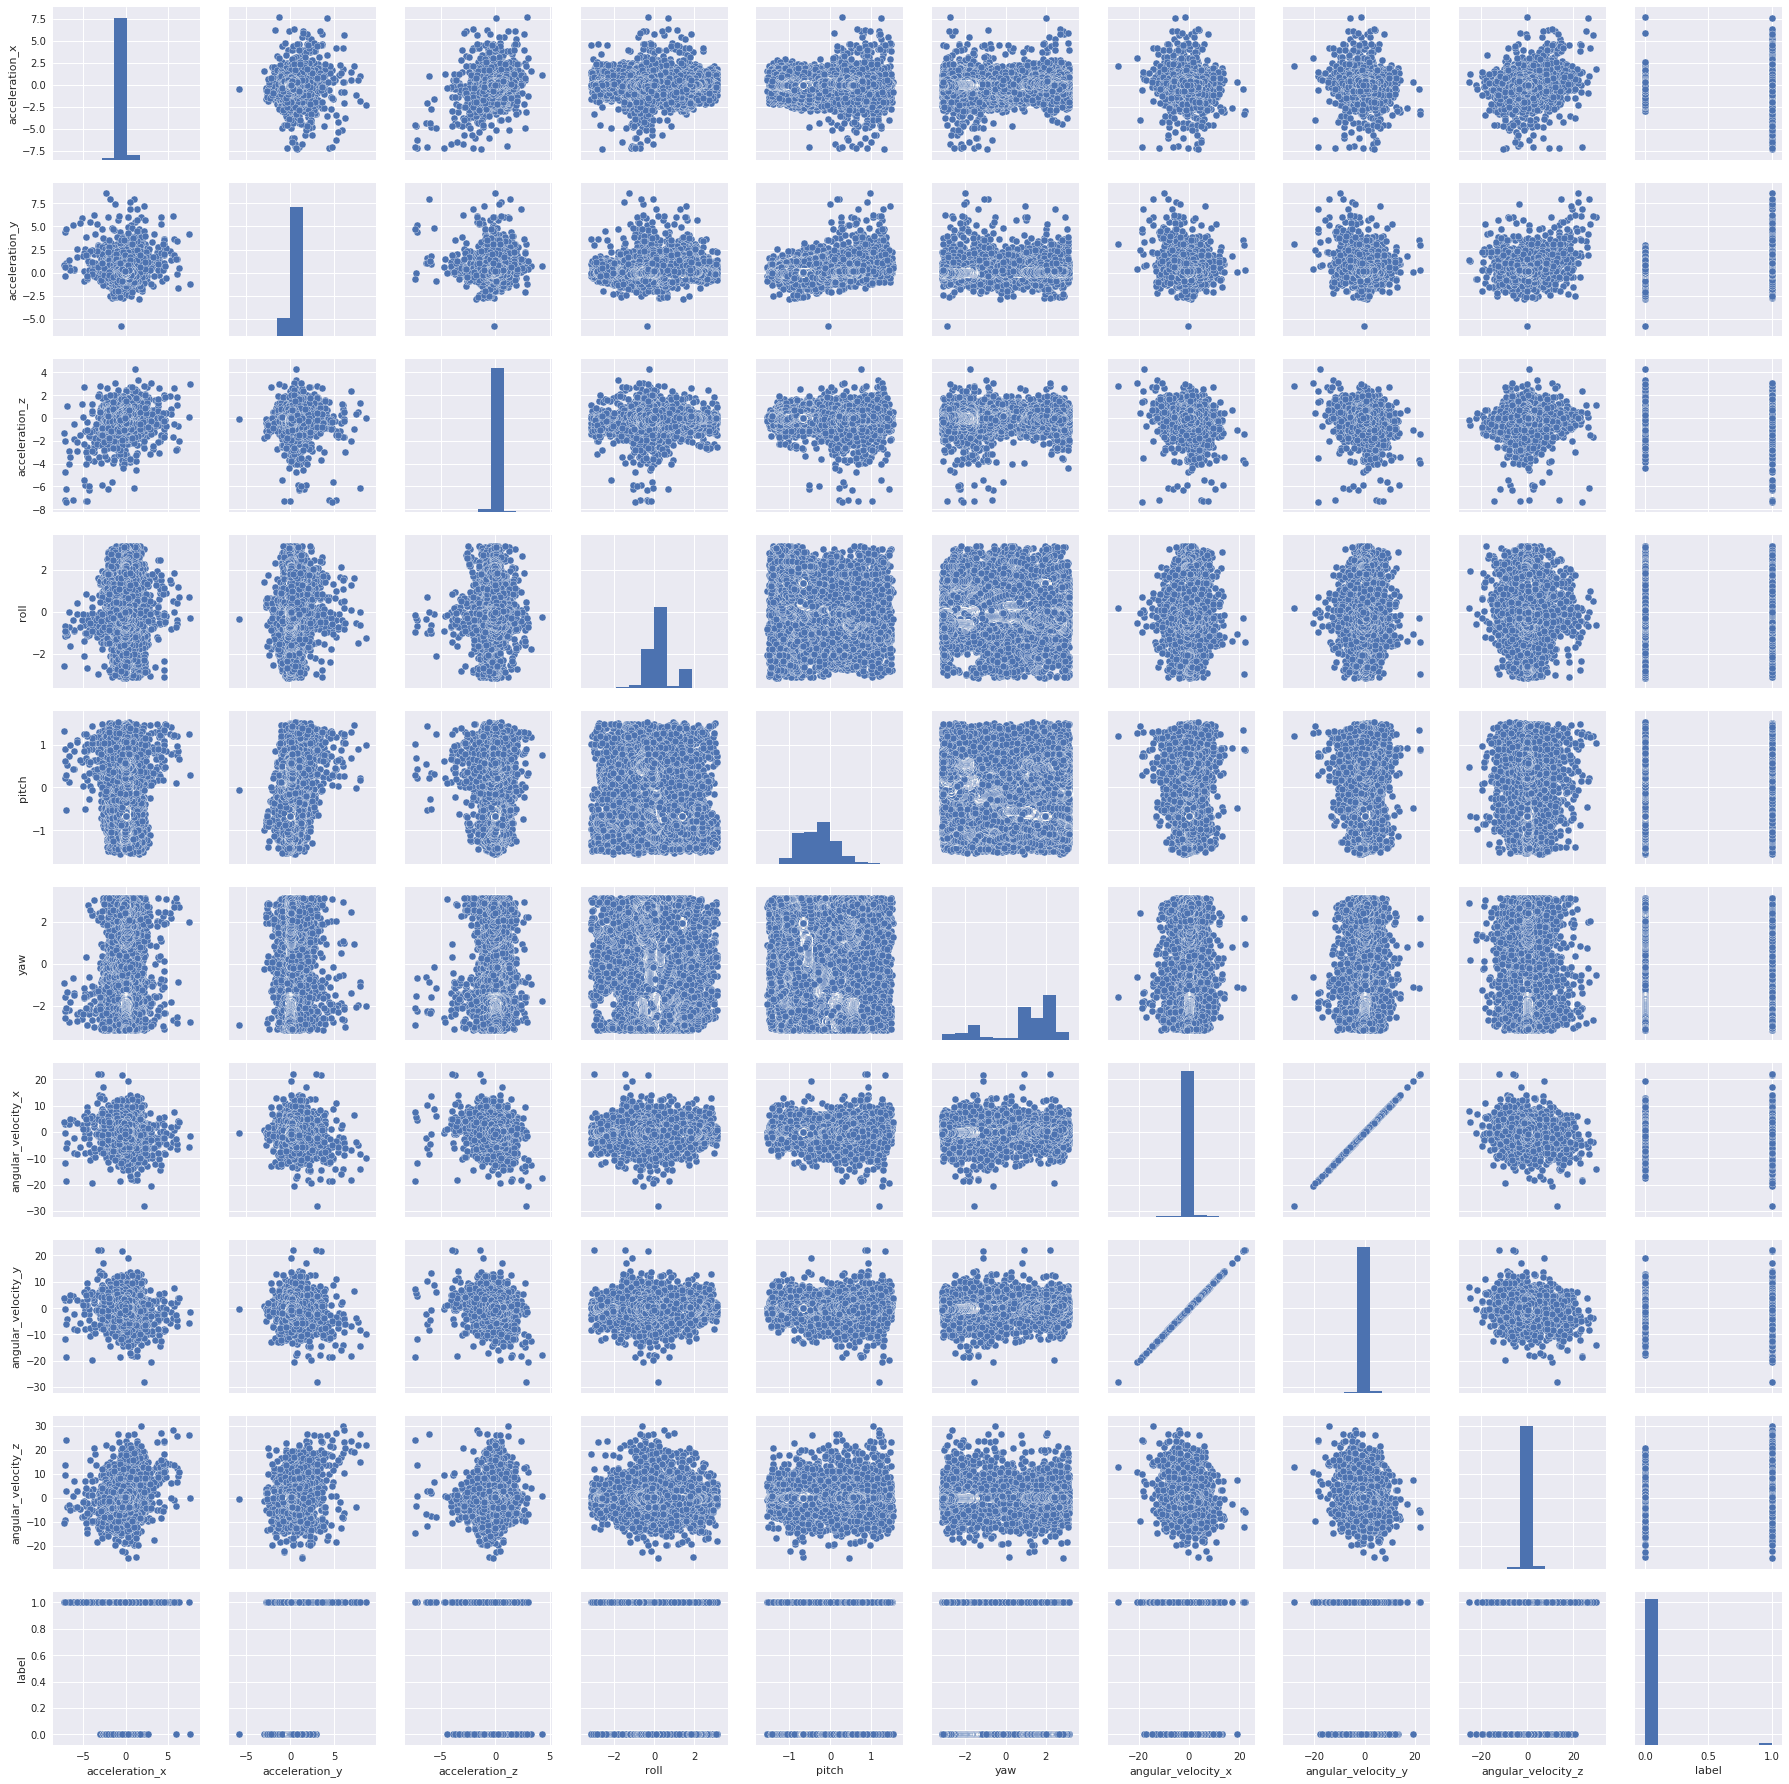

In [20]:
sns.pairplot(base[pair_cols]);

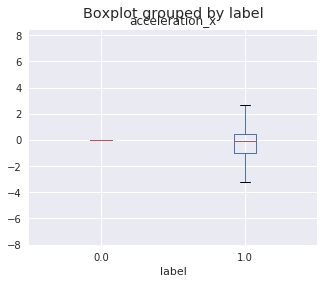

In [21]:
# using pandas boxplot 
base.boxplot('acceleration_x',by = 'label',grid = True,figsize=(5,4));
#sns.catplot(x="acceleration_x", y="label", data=base);

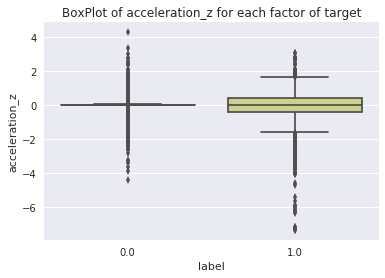

In [26]:
# using seaborn boxplot
var = 'acceleration_z'
sns.boxplot(x='label',y=var,data=base,palette='rainbow').set_title(f'BoxPlot of {var} for each factor of target');

In [20]:
features = base.head().drop(['timestamp','data_name_x', 'label', 'data_name_y', 'timestamp_tar'],axis = 1).columns
features

Index(['acceleration_x', 'acceleration_y', 'acceleration_z', 'roll', 'pitch',
       'yaw', 'angular_velocity_x', 'angular_velocity_y',
       'angular_velocity_z'],
      dtype='object')

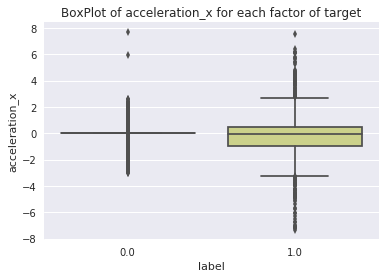

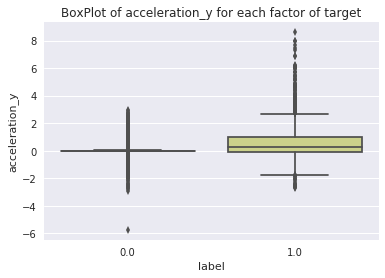

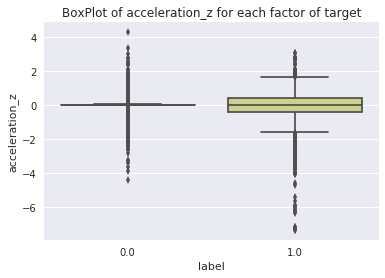

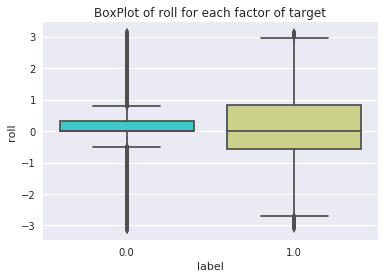

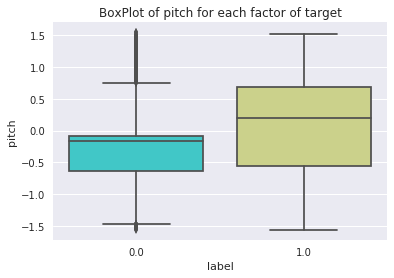

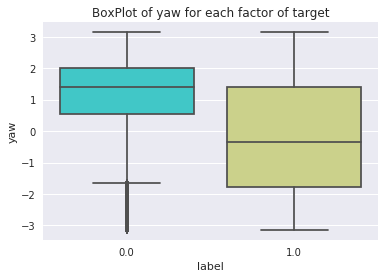

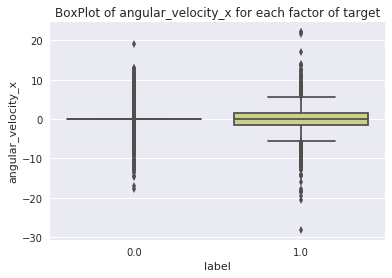

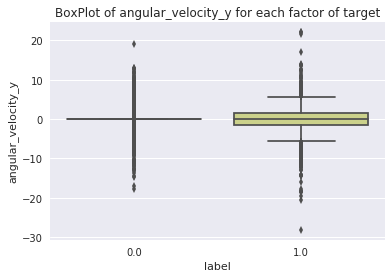

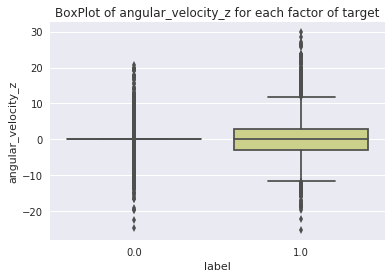

In [30]:
for i in features:
    pfig = plt.figure();
    img = sns.boxplot(x='label',y=i,data=base,palette='rainbow').set_title(f'BoxPlot of {i} for each factor of target');
    fig = img.get_figure();
    fig.savefig(i);
    #fig.clf(); # run this for not printing figure

In [23]:
cor_mat = base[features].corr()

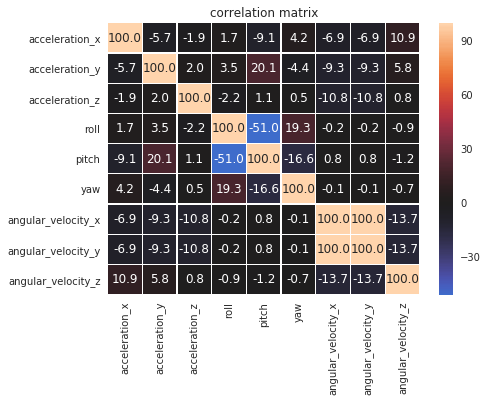

In [24]:
#https://seaborn.pydata.org/generated/seaborn.heatmap.html
fig, ax = plt.subplots(figsize=(7,5)) ;
x = sns.heatmap(100*cor_mat, annot=True,fmt='.1f',center=0,linewidths = 0.25).set_title('correlation matrix')
plt.show()

### checking vars with high(0.65) corr coeff

In [27]:
var1 = []; var2 = []
for i in range(len(cor_mat.columns)):
    for j in range(len(cor_mat.index)):
        if (cor_mat.iloc[i,j] > 0.65) & (i>j):
            var1.append(cor_mat.columns[i]); var2.append(cor_mat.index[j])
high_cor_var = list(zip(var1,var2))
high_cor_var[0][0],high_cor_var[0][1]

('angular_velocity_y', 'angular_velocity_x')

In [ ]:
high_cor_var[0][1]

### removing features with high correlation

In [28]:
features = [a for a in features if a not in [a for a,b in high_cor_var]] # removing var1
features

['acceleration_x',
 'acceleration_y',
 'acceleration_z',
 'roll',
 'pitch',
 'yaw',
 'angular_velocity_x',
 'angular_velocity_z']

In [ ]:
base.acceleration_x.std()

### tagging as outlier 

In [42]:
def rem_xsd_more(data_col,th=3):
    mean = data_col.mean()
    std = data_col.std()
    return((data_col-mean)/std>th)
# true means outlier , false means not

In [54]:
def rem_xpctl_more(data_col,pctl_th=0.99):
    pctl = data_col.quantile(pctl_th)
    return data_col>pctl
# true means outlier , false means not

In [59]:
base.reset_index(drop=True,inplace=True)

In [67]:
sd_out = 1*(base[features].apply(rem_xsd_more).sum(axis = 1)>0)
sd_out.value_counts()

0    156321
1      7520
dtype: int64

In [68]:
pctl_out = 1*(base[features].apply(rem_xpctl_more).sum(axis = 1)>0)
pctl_out.value_counts()

0    154866
1      8975
dtype: int64

In [80]:
dev_base = base.loc[(base.index.isin(sd_out[sd_out==0].index))&(base.index.isin(pctl_out[pctl_out==0].index))].\
        reset_index(drop = True)

In [83]:
import gc
del sd_out, pctl_out
gc.collect()

556

In [133]:
base.head()

,timestamp,acceleration_x,acceleration_y,acceleration_z,roll,pitch,yaw,angular_velocity_x,angular_velocity_y,angular_velocity_z,data_name_x,label,data_name_y,timestamp_tar
0,1396948626717,0.0008,0.0038,-0.0054,-0.0217,0.0018,0.0000,-0.0010,-0.0010,-0.0014,m,0.0,m,1396949162159
1,1396948626816,0.0025,-0.0047,-0.0093,-0.0216,0.0019,-0.0001,-0.0022,-0.0022,0.0023,m,0.0,m,1396949162159
2,1396948626915,-0.0001,-0.0004,-0.0074,-0.0208,0.0014,-0.0003,0.0014,0.0014,-0.0026,m,0.0,m,1396949162159
3,1396948627015,0.0027,-0.0006,-0.0054,-0.0207,0.0012,-0.0004,-0.0010,-0.0010,-0.0001,m,0.0,m,1396949162159
4,1396949160862,-0.0007,0.0350,0.0069,0.1381,0.2162,-0.0150,0.0885,0.0885,0.0309,m,0.0,m,1396949162159


### Modelling shuru

In [94]:
base.isna().sum()

timestamp             0
acceleration_x        0
acceleration_y        0
acceleration_z        0
roll                  0
pitch                 0
yaw                   0
angular_velocity_x    0
angular_velocity_y    0
angular_velocity_z    0
data_name_x           0
label                 0
data_name_y           0
timestamp_tar         0
dtype: int64

In [95]:
features

['acceleration_x',
 'acceleration_y',
 'acceleration_z',
 'roll',
 'pitch',
 'yaw',
 'angular_velocity_x',
 'angular_velocity_z']

In [109]:
X_train, X_test, y_train, y_test = train_test_split(base[features],\
                base.label,test_size = 0.25, random_state = 51, stratify = base.label)

In [110]:
X_train.shape, X_test.shape

((122880, 8), (40961, 8))

In [111]:
y_train.value_counts(normalize = True)

0.0    0.984448
1.0    0.015552
Name: label, dtype: float64

### remember pipeline with stdsclaer and model

In [118]:
scl = StandardScaler()
logreg = LogisticRegression(max_iter = 10000, tol = 1e-6,random_state = 51,class_weight = {0:0.02,1:0.98})# 'balanced')

In [119]:
pipe = Pipeline([('sc', scl), ('lr', logreg)])

In [120]:
pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('sc',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('lr',
                 LogisticRegression(C=1.0, class_weight={0: 0.02, 1: 0.98},
                                    dual=False, fit_intercept=True,
                                    intercept_scaling=1, l1_ratio=None,
                                    max_iter=10000, multi_class='auto',
                                    n_jobs=None, penalty='l2', random_state=51,
                                    solver='lbfgs', tol=1e-06, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [121]:
estimator= pipe
pred_bin_tr = estimator.predict(X_train)
pred_bin_te = estimator.predict(X_test)
f'train_roca : {roc_auc_score(y_train,estimator.predict_proba(X_train)[:,1])} ; test_roca : {roc_auc_score(y_test,estimator.predict_proba(X_test)[:,1])}'
f'train_f1_s : {f1_score(y_train,pred_bin_tr)} ; test_f1_s : {f1_score(y_test,pred_bin_te)}'
f'train_prec : {precision_score(y_train,pred_bin_tr)} ; test_prec : {precision_score(y_test,pred_bin_te)}'
f'train_reca : {recall_score(y_train,pred_bin_tr)} ; test_reca : {recall_score(y_test,pred_bin_te)}'
f'train_accu : {accuracy_score(y_train,pred_bin_tr)} ; test_accu : {accuracy_score(y_test,pred_bin_te)}'
f'train_conf : {confusion_matrix(y_train,pred_bin_tr)} ; test_conf : {confusion_matrix(y_test,pred_bin_te)}'

'train_roca : 0.7664128385163171 ; test_roca : 0.7759825554297474'

'train_f1_s : 0.08813227373733569 ; test_f1_s : 0.08836689038031321'

'train_prec : 0.04748376623376623 ; test_prec : 0.04757316632542455'

'train_reca : 0.6122448979591837 ; test_reca : 0.6200941915227629'

'train_accu : 0.8029703776041667 ; test_accu : 0.801030248284954'

'train_conf : [[97499 23470]\n [  741  1170]] ; test_conf : [[32416  7908]\n [  242   395]]'

In [135]:
%%time
rf = RandomForestClassifier(max_depth = 7,)
rf.fit(X_train, y_train)

CPU times: user 9.74 s, sys: 3.93 ms, total: 9.74 s
Wall time: 9.74 s


In [125]:
estimator= rf
pred_bin_tr = estimator.predict(X_train)
pred_bin_te = estimator.predict(X_test)
f'train_roca : {roc_auc_score(y_train,estimator.predict_proba(X_train)[:,1])} ; test_roca : {roc_auc_score(y_test,estimator.predict_proba(X_test)[:,1])}'
f'train_f1_s : {f1_score(y_train,pred_bin_tr)} ; test_f1_s : {f1_score(y_test,pred_bin_te)}'
f'train_prec : {precision_score(y_train,pred_bin_tr)} ; test_prec : {precision_score(y_test,pred_bin_te)}'
f'train_reca : {recall_score(y_train,pred_bin_tr)} ; test_reca : {recall_score(y_test,pred_bin_te)}'
f'train_accu : {accuracy_score(y_train,pred_bin_tr)} ; test_accu : {accuracy_score(y_test,pred_bin_te)}'
f'train_conf : {confusion_matrix(y_train,pred_bin_tr)} ; test_conf : {confusion_matrix(y_test,pred_bin_te)}'

'train_roca : 1.0 ; test_roca : 0.9774394905192586'

'train_f1_s : 0.9997382884061764 ; test_f1_s : 0.44888888888888895'

'train_prec : 1.0 ; test_prec : 0.7680608365019012'

'train_reca : 0.9994767137624281 ; test_reca : 0.31711145996860285'

'train_accu : 0.9999918619791667 ; test_accu : 0.9878909206318205'

'train_conf : [[120969      0]\n [     1   1910]] ; test_conf : [[40263    61]\n [  435   202]]'

In [129]:
skf = StratifiedKFold(n_splits=5, shuffle = True,random_state = 51)

In [137]:
dict(zip(features,rf.feature_importances_))

{'acceleration_x': 0.2114620497484284,
 'acceleration_y': 0.26664375243299,
 'acceleration_z': 0.11217718770410565,
 'roll': 0.03540898685745663,
 'pitch': 0.05732951143302856,
 'yaw': 0.02739155343047068,
 'angular_velocity_x': 0.10778383543158324,
 'angular_velocity_z': 0.18180312296193687}

In [134]:
estimator = rf
cv_result = cross_val_score(estimator=estimator, X=base[features], y=base.label, \
                                      cv=skf, scoring = 'f1')
cv_result
print("Full Accuracy: %0.2f(+/- %0.2f)" % (cv_result.mean(), cv_result.std()*2))

array([0.39130435, 0.42458101, 0.42      , 0.44628099, 0.41054092])

Full Accuracy: 0.42(+/- 0.04)


In [ ]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler,MaxAbsScaler

In [126]:
%%time
xgb = XGBClassifier()
xgb.fit(X_train, y_train)

CPU times: user 4.79 s, sys: 11.6 ms, total: 4.8 s
Wall time: 4.83 s


In [128]:
estimator= xgb
pred_bin_tr = estimator.predict(X_train)
pred_bin_te = estimator.predict(X_test)
f'train_roca : {roc_auc_score(y_train,estimator.predict_proba(X_train)[:,1])} ; test_roca : {roc_auc_score(y_test,estimator.predict_proba(X_test)[:,1])}'
f'train_f1_s : {f1_score(y_train,pred_bin_tr)} ; test_f1_s : {f1_score(y_test,pred_bin_te)}'
f'train_prec : {precision_score(y_train,pred_bin_tr)} ; test_prec : {precision_score(y_test,pred_bin_te)}'
f'train_reca : {recall_score(y_train,pred_bin_tr)} ; test_reca : {recall_score(y_test,pred_bin_te)}'
f'train_accu : {accuracy_score(y_train,pred_bin_tr)} ; test_accu : {accuracy_score(y_test,pred_bin_te)}'
f'train_conf : {confusion_matrix(y_train,pred_bin_tr)} ; test_conf : {confusion_matrix(y_test,pred_bin_te)}'

'train_roca : 0.9818127849258611 ; test_roca : 0.977505459311757'

'train_f1_s : 0.4021952175617404 ; test_f1_s : 0.3812865497076024'

'train_prec : 0.8015625 ; test_prec : 0.7477064220183486'

'train_reca : 0.2684458398744113 ; test_reca : 0.25588697017268447'

'train_accu : 0.9875895182291666 ; test_accu : 0.987085276238373'

'train_conf : [[120842    127]\n [  1398    513]] ; test_conf : [[40269    55]\n [  474   163]]'